# There's Gold in Them Hills... right?

It's time for a little bit of Minecraft Myth Busting, as X would say.

Allegedly, gold is much easier to find in the Badlands with a uniform density from y=32 up to y=256

![ore distribution 1.18-1.20.1](../_static/ore_chart.png)

but at higher y-levels, most of the badlands is made up of terracotta, and I've never seen any type of ore in the middle of terracotta. So should you _really_ be digging into the hearts of mountains to look for gold? Or are you better off searching at, say, y~40?

## Creating a Test World

Rather than analyze one of my existing worlds, I chose to create a new one from scratch, first using [chunkbase to find a world with a good-sized badland](https://www.chunkbase.com/apps/seed-map#-1099639228980812746), then generating that world in a vanilla Minecraft 1.20 instance, teleporting to the center of the badlands,

![Badland to the bone](../_static/badlands.png)

letting the chunks generate, then using [MCA Selector](https://github.com/Querz/mcaselector) to trim out all the non-badlands biomes.

I also teleported to (0, 128, 0) in the nether to generate some nether chunks for comparison.

## Imports, Setup and Macros

In [1]:
import json
from collections import Counter, defaultdict
from os import environ
from pathlib import Path
from typing import Any, Collection, Dict, List, Tuple

import matplotlib.pyplot as plt
import mutf8
import pandas as pd
from IPython.display import Markdown, display
from nbt import nbt, region

In [2]:
save_folder = Path(environ["SAVE_PATH"])

In [3]:
def summarize_keystore(keystore: Dict[str, Any]) -> None:
    """Display a summary of the contents of a key-value store

    Parameters
    ----------
    keystore : dict
        The keystore to summarize

    Returns
    -------
    None
    """

    def _summarize_keystore(keystore: Dict[str, Any]) -> str:
        summary = ""
        for k, v in keystore.items():
            summary += f"\n - `{k}` : "
            if isinstance(v, (str, nbt.TAG_String)):
                summary += f'`"{v}"`'
            elif not isinstance(v, Collection):
                summary += f"`{str(v)}`"
            else:
                length = len(v)
                if 0 < length < 3:
                    summary += "\n"
                    if not isinstance(v, Dict):
                        v = {i: item for i, item in enumerate(v)}
                    summary += "\n".join(
                        (f"\t{line}" for line in _summarize_keystore(v).split("\n"))
                    )
                else:
                    summary += f"({len(v)} items)"
        return summary

    display(Markdown(_summarize_keystore(keystore)))

In [4]:
def split_block_value(value: int) -> List[int]:
    """Split a 64-bit int into 16x 4-bit ints

    Parameters
    ----------
    value: 64-bit int
        The int to split

    Returns
    -------
    list of 16x 4-bit ints
    """
    small_ints: List[int] = []
    for _ in range(16):
        value, remainder = divmod(value, 2**4)
        small_ints.append(remainder)
    return small_ints

In [5]:
def get_region_and_chunk(
    coords: tuple[int, int, int]
) -> tuple[tuple[int, int], tuple[int, int, int]]:
    """Given a set of coordinates return the corresponding
    region file and chunk

    Parameters
    ----------
    (int, int, int)
        The block coordinates

    Returns
    -------
    str
        The region index
    (int, int, int)
        The chunk index (including y-sliced sub-chunk)
    """
    chunk: tuple[int, int, int] = tuple(coord // 16 for coord in coords)  # type: ignore
    region = (chunk[0] // 32, chunk[2] // 32)
    return region, chunk

## Chunk Contents

Cribbing from the [Iron Vein finding notebook](Finding%20an%20Iron%20Vein.ipynb), the name of the game is combing through each chunklet and finding the ones *containing* the blocks we want, then finding out *how many* such blocks are in that chunklet.

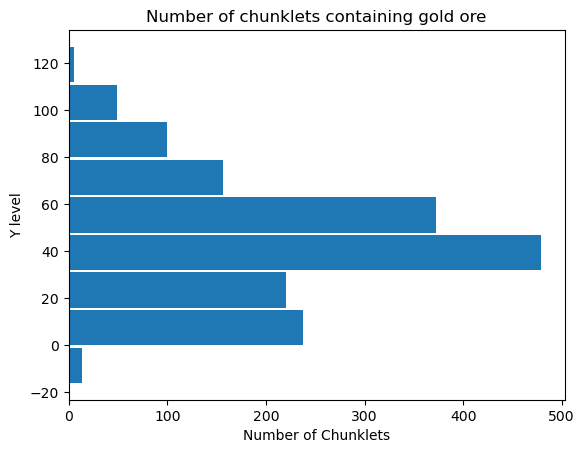

CPU times: user 986 ms, sys: 134 ms, total: 1.12 s
Wall time: 1e+03 ms


In [6]:
%%time
n_chunks = 0
gold_chunklets: dict[int, list[nbt.TAG_Compound]] = defaultdict(list)
for region_file in sorted((save_folder / "region").glob("*")):
    if region_file.name == "r.0.0.mca":
        continue
    region_data = region.RegionFile(region_file)
    for chunk in region_data.iter_chunks():
        n_chunks += 1
        for section in chunk["sections"]:
            # explicitly ignoring deepslate gold ore
            if "minecraft:gold_ore" in [
                block["Name"].value for block in section["block_states"]["palette"]
            ]:
                gold_chunklets[section["Y"].value * 16].append(section)

fig, ax = plt.subplots()
ax.barh(
    *zip(*((y, len(chunklets)) for y, chunklets in gold_chunklets.items())),
    height=15,
    align="edge",
)
ax.set_title("Number of chunklets containing gold ore")
ax.set_ylabel("Y level")
ax.set_xlabel("Number of Chunklets")
plt.show(fig)

Now let's convert that to total ore.

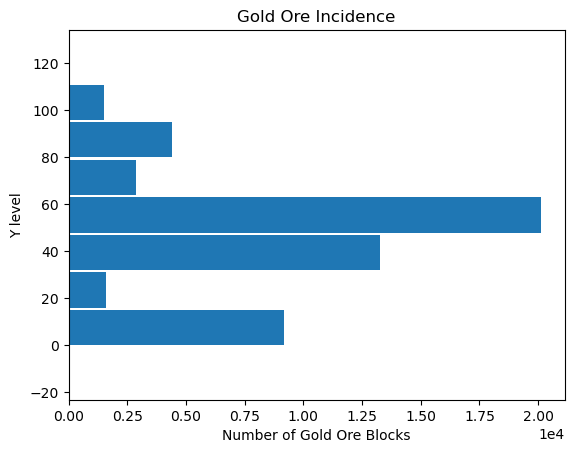

CPU times: user 2.45 s, sys: 101 ms, total: 2.55 s
Wall time: 2.43 s


In [7]:
%%time
gold_count: dict[int, int] = {}
for y, chunklets in gold_chunklets.items():
    ore_count = 0
    for chunklet in chunklets:
        palette: list[str] = [
            block["Name"].value for block in chunklet["block_states"]["palette"]
        ]
        ore_idx = palette.index("minecraft:gold_ore")
        block_counts = Counter(
            sum(
                [split_block_value(v) for v in chunklet["block_states"]["data"]],
                [],
            )
        )
        ore_count += block_counts.get(ore_idx, 0)
    gold_count[y] = ore_count

fig, ax = plt.subplots()
ax.barh(
    *zip(*gold_count.items()),
    height=15,
    align="edge",
)
ax.set_title("Gold Ore Incidence")
ax.set_ylabel("Y level")
ax.set_xlabel("Number of Gold Ore Blocks")
ax.ticklabel_format(axis="x", style="sci", scilimits=(-4, 4))
plt.show(fig)

So in terms of _absolute_ quantity of ores, you're actually better off mining at y=48-64, which is interesting!

## Normalized Counts

But what about if we subtract air, water, etc and look at percentage of _mineable_ blocks?

In [8]:
# blockz: set[str] = set()
# for region_file in sorted((save_folder / "region").glob("*")):
#     region_data = region.RegionFile(region_file)
#     for chunk in region_data.iter_chunks():
#         n_chunks += 1
#         for section in chunk["sections"]:
#             blockz.update( [
#                 block["Name"].value for block in section["block_states"]["palette"]
#             ])
# blockz

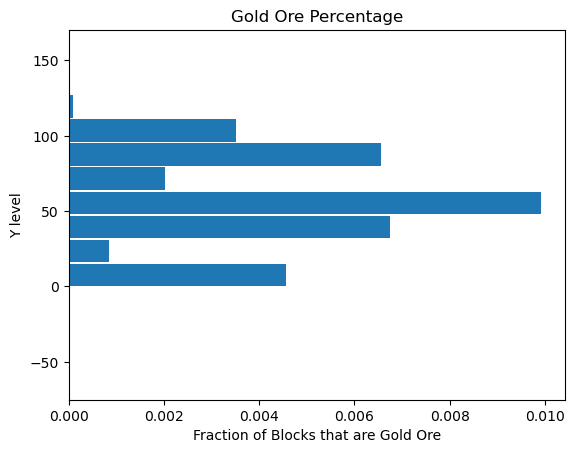

CPU times: user 8.6 s, sys: 116 ms, total: 8.71 s
Wall time: 8.6 s


In [9]:
%%time

gold_count = defaultdict(int)
denominator: dict[int, int] = defaultdict(int)
for region_file in sorted((save_folder / "region").glob("*")):
    if region_file.name == "r.0.0.mca":
        continue
    region_data = region.RegionFile(region_file)
    for chunk in region_data.iter_chunks():
        for section in chunk["sections"]:
            if "data" not in section["block_states"]:
                # then it's all a single block,
                # probably air or water
                continue
            block_counts = Counter(
                sum(
                    [split_block_value(v) for v in section["block_states"]["data"]],
                    [],
                )
            )
            block_lookup: list[str] = [
                block["Name"].value for block in section["block_states"]["palette"]
            ]
            ore_count = 0
            mineable_block_count = 0
            for i, count in block_counts.items():
                if block_lookup[i] == "minecraft:gold_ore":
                    # this could just be "="
                    ore_count += count
                if block_lookup[i] not in (
                    "minecraft:air",
                    "minecraft:water",
                    "minecraft:lava",
                    "minecraft:cave_air",
                    # there are actually a ton more "non-full blocks"
                    # like torches, cobwebs and dandelions
                    # but we'll assume those are rounding errors
                ):
                    mineable_block_count += count

            gold_count[section["Y"].value * 16] += ore_count
            denominator[section["Y"].value * 16] += mineable_block_count

ys = sorted(gold_count.keys())
pcts = [gold_count[y] / denominator[y] for y in ys]

fig, ax = plt.subplots()
ax.barh(
    ys,
    pcts,
    height=15,
    align="edge",
)
ax.set_title("Gold Ore Percentage")
ax.set_ylabel("Y level")
ax.set_xlabel("Fraction of Blocks that are Gold Ore")
ax.ticklabel_format(axis="x", style="sci", scilimits=(-4, 4))
plt.show(fig)

So even subtracting out the air (and water and lava) blocks, y=48-64 is the way to go! But I'm still skeptical that I'm supposed to be finding gold mixed in with terracotta. Does gold ore maybe only generate in areas without terracotta?

In [10]:
%%time

terracotta_to_gold_ratios: list[float] = []
stone_to_gold_ratios: list[float] = []
n = 0

for region_file in sorted((save_folder / "region").glob("*")):
    if region_file.name == "r.0.0.mca":
        continue
    region_data = region.RegionFile(region_file)
    for chunk in region_data.iter_chunks():
        for section in chunk["sections"]:
            if "data" not in section["block_states"]:
                continue
            if section["Y"].value * 16 != 48:
                continue
            n += 1
            block_counts = Counter(
                sum(
                    [split_block_value(v) for v in section["block_states"]["data"]],
                    [],
                )
            )
            block_lookup = [
                block["Name"].value for block in section["block_states"]["palette"]
            ]
            ore_count = 0
            terracotta_count = 0
            stone_count = 0
            for i, count in block_counts.items():
                if block_lookup[i] == "minecraft:gold_ore":
                    # this could just be "="
                    ore_count += count
                elif block_lookup[i] in (
                    "minecraft:stone",
                    "minecraft:andesite",
                    "minecraft:diorite",
                    "minecraft:granite",
                ):
                    stone_count += count
                elif block_lookup[i].endswith("terracotta"):
                    terracotta_count += count
            if ore_count == 0:
                continue

            terracotta_to_gold_ratios.append(terracotta_count / ore_count)
            stone_to_gold_ratios.append(stone_count / ore_count)

CPU times: user 1.72 s, sys: 6.64 ms, total: 1.73 s
Wall time: 1.73 s


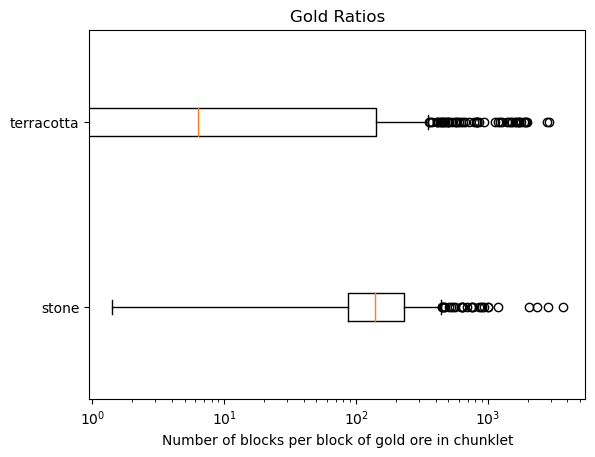

In [11]:
fig, ax = plt.subplots()
ax.boxplot(
    (stone_to_gold_ratios, terracotta_to_gold_ratios),
    vert=False,
    labels=("stone", "terracotta"),
)
ax.set_title("Gold Ratios")
ax.set_xlabel("Number of blocks per block of gold ore in chunklet")
ax.set_xscale("log")
plt.show(fig)

Yeah, bingo--**gold does not generate within terracotta**, so if you're digging in terracotta, you're too high up.

## Best y level?

So far we've been working with 16-block-tall "chunklets," which is good enough for a rough analysis, but it's not enough to tell us *precisely* which y-level to dig at to get gold. The reason is that the block data is just one 4096-length ($16^3$) array, with [nothing in the wiki](https://minecraft.fandom.com/wiki/Chunk_format#NBT_structure) saying how to convert from index to (x, y, z).

Luckily, we worked this out in [another notebook](Hitting%20a%20Block.ipynb).

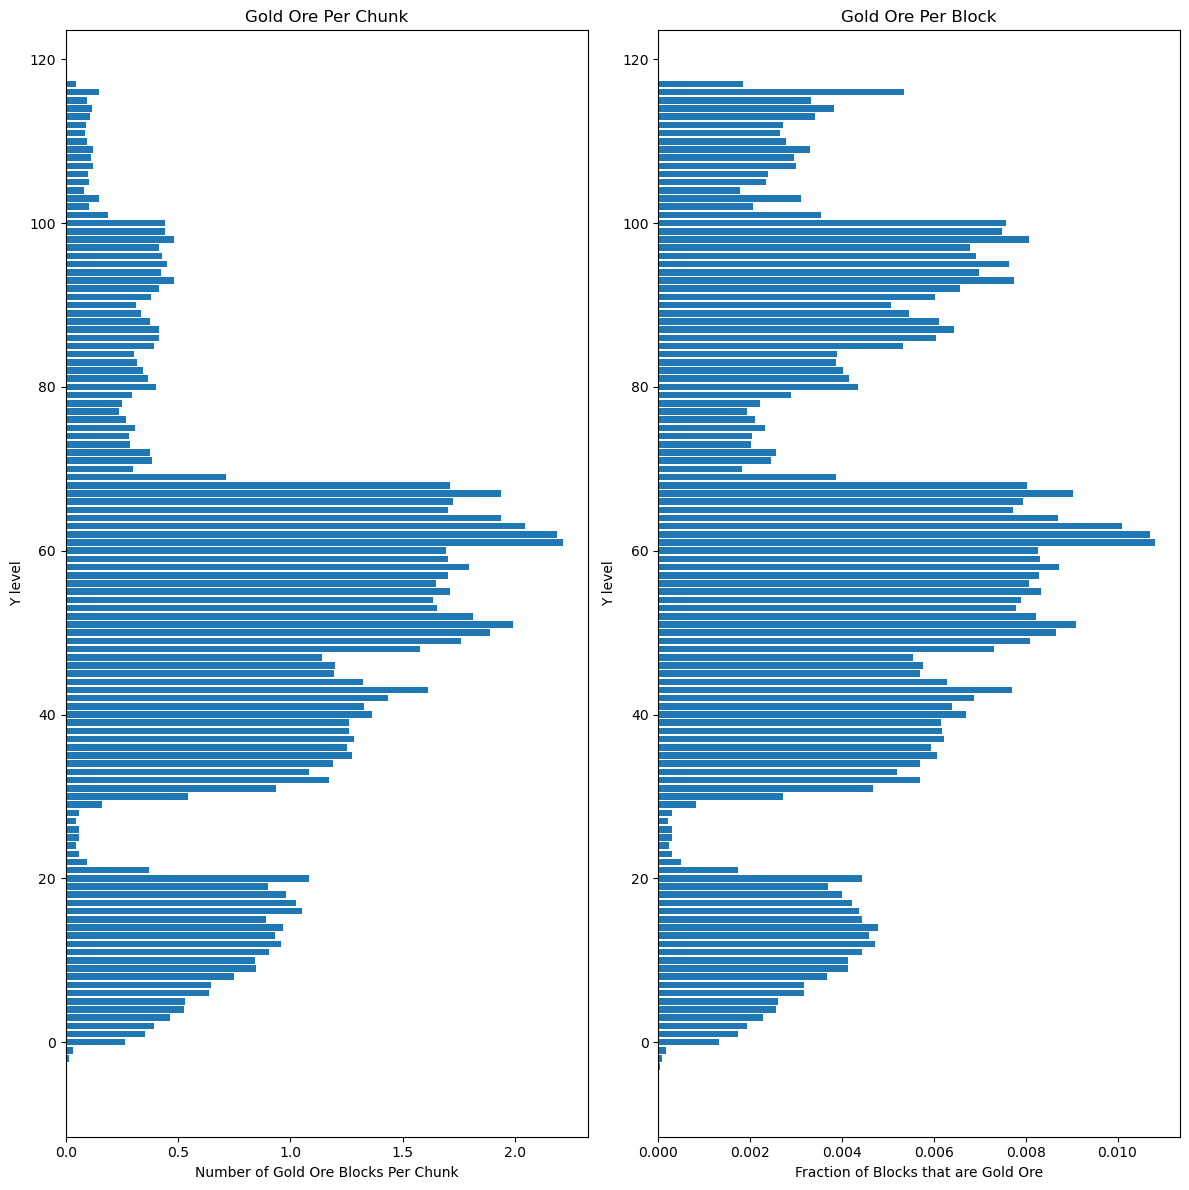

CPU times: user 24.5 s, sys: 143 ms, total: 24.6 s
Wall time: 24.5 s


In [12]:
%%time
gold_count = defaultdict(int)
denominator = defaultdict(int)
n_chunks = 0
for region_file in sorted((save_folder / "region").glob("*")):
    if region_file.name == "r.0.0.mca":
        continue
    region_data = region.RegionFile(region_file)
    for chunk in region_data.iter_chunks():
        n_chunks += 1
        for section in chunk["sections"]:
            if "data" not in section["block_states"]:
                continue

            block_lookup = [
                block["Name"].value for block in section["block_states"]["palette"]
            ]
            blocks: list[int] = sum(
                [split_block_value(v) for v in section["block_states"]["data"]],
                [],
            )
            for idx, i in enumerate(
                sum(
                    [split_block_value(v) for v in section["block_states"]["data"]],
                    [],
                )
            ):
                y = section["Y"].value * 16 + (idx // 256)

                if block_lookup[i] == "minecraft:gold_ore":
                    gold_count[y] += 1

                if block_lookup[i] not in (
                    "minecraft:air",
                    "minecraft:water",
                    "minecraft:lava",
                    "minecraft:cave_air",
                ):
                    denominator[y] += 1


ys = sorted(gold_count.keys())
per_chunk = [gold_count[y] / n_chunks for y in ys]
pcts = [gold_count[y] / denominator[y] for y in ys]


fig, axs = plt.subplots(1, 2, figsize=(12, 12))
axs[0].barh(
    ys,
    per_chunk,
    height=0.8,
    align="center",
)
axs[0].set_title("Gold Ore Per Chunk")
axs[0].set_ylabel("Y level")
axs[0].set_xlabel("Number of Gold Ore Blocks Per Chunk")
axs[0].ticklabel_format(axis="x", style="sci", scilimits=(-4, 4))

axs[1].barh(
    ys,
    pcts,
    height=0.8,
    align="center",
)
axs[1].set_title("Gold Ore Per Block")
axs[1].set_ylabel("Y level")
axs[1].set_xlabel("Fraction of Blocks that are Gold Ore")
axs[1].ticklabel_format(axis="x")
fig.tight_layout()
plt.show(fig)

So whether we're talking absolutely or relatively, your best bet for gold hunting in the badlands appears to be at around y=60, where you can expect to get just over 2 gold ore blocks per chunk. And in terms of _general strategy_, what this probably works out to is:

1. Go to the **red sand floor** of the badlands
2. Dig down until you're *right under* the terracotta layer
3. Branch mine until you're rich

## What About The Nether?

Obviously there are reasons to prefer mining in badlands--especially in non-deepslate levels--over The Nether, but let's get a comparative analysis in place.

In [13]:
# blockz: set[str] = set()
# for region_file in sorted((save_folder / "DIM-1" / "region").glob("*")):
#     region_data = region.RegionFile(region_file)
#     for chunk in region_data.iter_chunks():
#         n_chunks += 1
#         for section in chunk["sections"]:
#             blockz.update( [
#                 block["Name"].value for block in section["block_states"]["palette"]
#             ])
# blockz

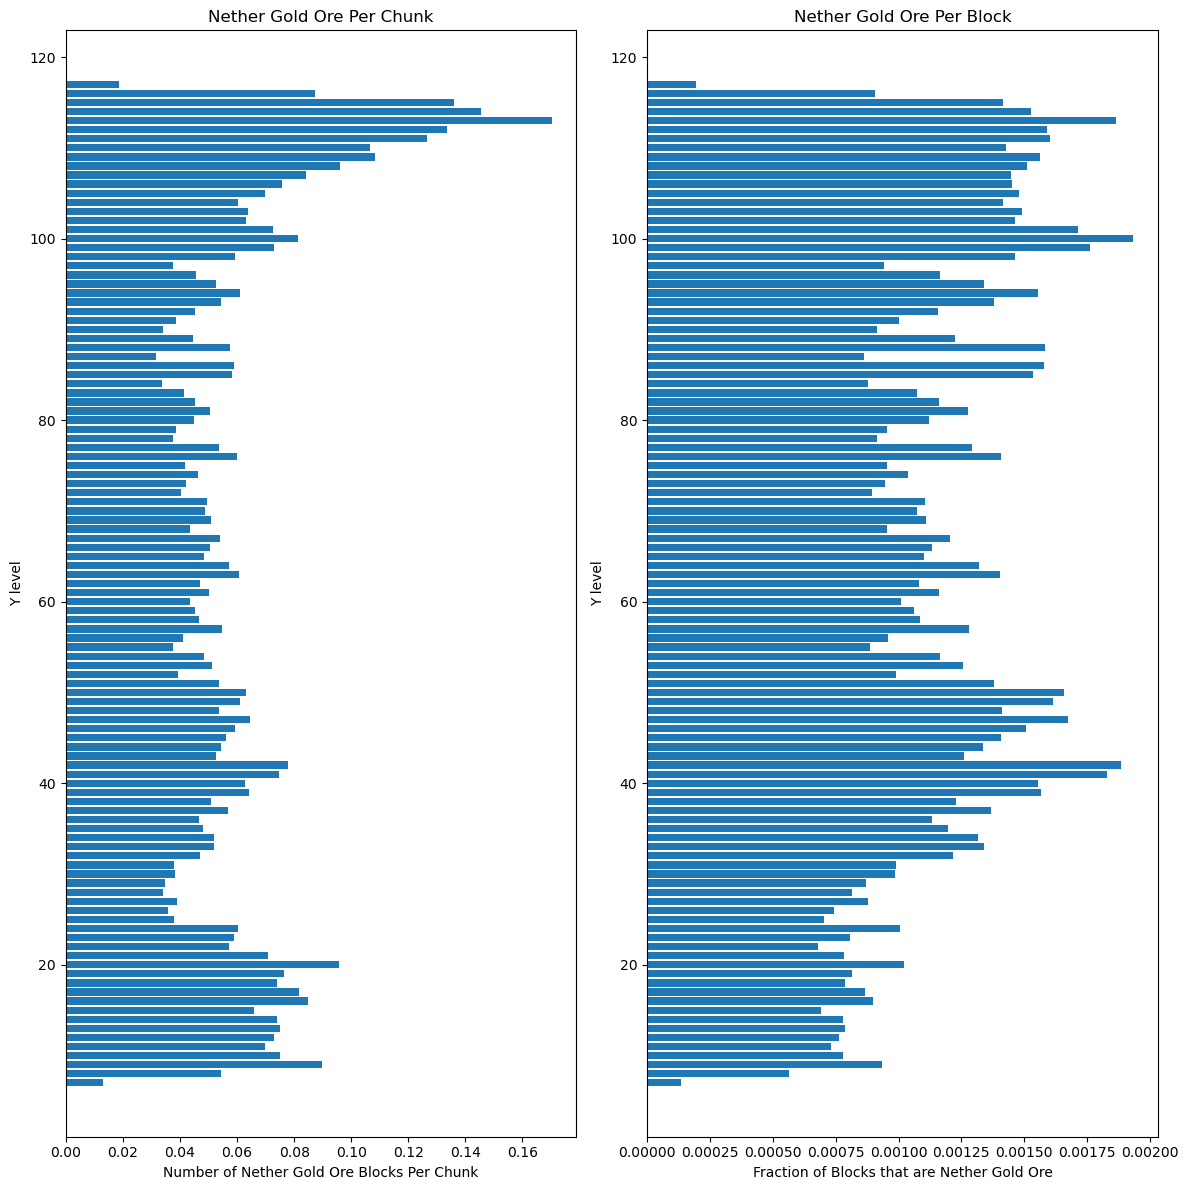

CPU times: user 30.4 s, sys: 193 ms, total: 30.6 s
Wall time: 30.4 s


In [14]:
%%time
gold_count = defaultdict(int)
denominator = defaultdict(int)
n_chunks = 0
for region_file in sorted((save_folder / "DIM-1" / "region").glob("*")):
    region_data = region.RegionFile(region_file)
    for chunk in region_data.iter_chunks():
        n_chunks += 1
        for section in chunk["sections"]:
            if "data" not in section["block_states"]:
                continue

            block_lookup = [
                block["Name"].value for block in section["block_states"]["palette"]
            ]
            blocks = sum(
                [split_block_value(v) for v in section["block_states"]["data"]],
                [],
            )
            for idx, i in enumerate(
                sum(
                    [split_block_value(v) for v in section["block_states"]["data"]],
                    [],
                )
            ):
                y = section["Y"].value * 16 + (idx // 256)

                if block_lookup[i] == "minecraft:nether_gold_ore":
                    gold_count[y] += 1

                if block_lookup[i] not in (
                    "minecraft:air",
                    "minecraft:cave_air",
                    "minecraft:water",
                    "minecraft:lava",
                    "minecraft:fire",
                    "minecraft:soul_fire",
                ):
                    denominator[y] += 1


ys = sorted(gold_count.keys())
per_chunk = [gold_count[y] / n_chunks for y in ys]
pcts = [gold_count[y] / denominator[y] for y in ys]


fig, axs = plt.subplots(1, 2, figsize=(12, 12))
axs[0].barh(
    ys,
    per_chunk,
    height=0.8,
    align="center",
)
axs[0].set_title("Nether Gold Ore Per Chunk")
axs[0].set_ylabel("Y level")
axs[0].set_xlabel("Number of Nether Gold Ore Blocks Per Chunk")
axs[0].ticklabel_format(axis="x", style="sci", scilimits=(-4, 4))

axs[1].barh(
    ys,
    pcts,
    height=0.8,
    align="center",
)
axs[1].set_title("Nether Gold Ore Per Block")
axs[1].set_ylabel("Y level")
axs[1].set_xlabel("Fraction of Blocks that are Nether Gold Ore")
axs[1].ticklabel_format(axis="x")
fig.tight_layout()
plt.show(fig)

**WOW!** according to this, you're about 1/5th as likely to come across nether gold mining in The Nether as you are to come across gold ore mining in the badlands--and in the Nether, you're mining for _nuggets!_

It's also pretty clear that you're better off mining right under the Nether Roof, as you're avoiding all that lava. Of course, you're losing out on the debris too... right?

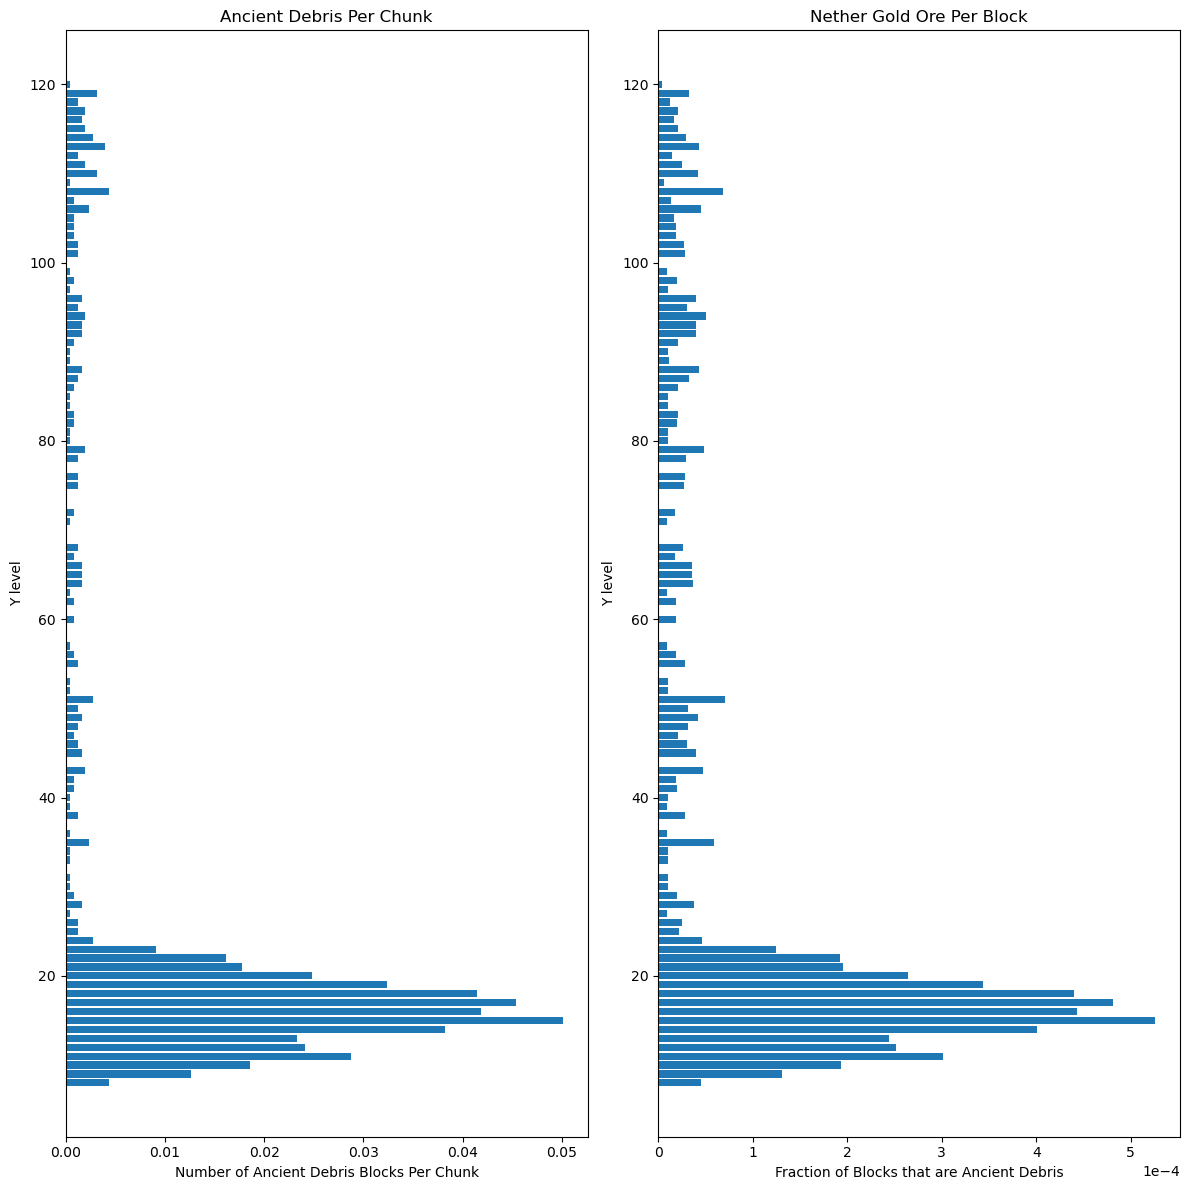

CPU times: user 30.5 s, sys: 157 ms, total: 30.6 s
Wall time: 30.5 s


In [15]:
%%time
debris_count: dict[int, int] = defaultdict(int)
denominator = defaultdict(int)
n_chunks = 0
for region_file in sorted((save_folder / "DIM-1" / "region").glob("*")):
    region_data = region.RegionFile(region_file)
    for chunk in region_data.iter_chunks():
        n_chunks += 1
        for section in chunk["sections"]:
            if "data" not in section["block_states"]:
                continue

            block_lookup = [
                block["Name"].value for block in section["block_states"]["palette"]
            ]
            blocks = sum(
                [split_block_value(v) for v in section["block_states"]["data"]],
                [],
            )
            for idx, i in enumerate(
                sum(
                    [split_block_value(v) for v in section["block_states"]["data"]],
                    [],
                )
            ):
                y = section["Y"].value * 16 + (idx // 256)

                if block_lookup[i] == "minecraft:ancient_debris":
                    debris_count[y] += 1

                if block_lookup[i] not in (
                    "minecraft:air",
                    "minecraft:cave_air",
                    "minecraft:water",
                    "minecraft:lava",
                    "minecraft:fire",
                    "minecraft:soul_fire",
                ):
                    denominator[y] += 1


ys = sorted(debris_count.keys())
per_chunk = [debris_count[y] / n_chunks for y in ys]
pcts = [debris_count[y] / denominator[y] for y in ys]


fig, axs = plt.subplots(1, 2, figsize=(12, 12))
axs[0].barh(
    ys,
    per_chunk,
    height=0.8,
    align="center",
)
axs[0].set_title("Ancient Debris Per Chunk")
axs[0].set_ylabel("Y level")
axs[0].set_xlabel("Number of Ancient Debris Blocks Per Chunk")
axs[0].ticklabel_format(axis="x", style="sci", scilimits=(-4, 4))

axs[1].barh(
    ys,
    pcts,
    height=0.8,
    align="center",
)
axs[1].set_title("Nether Gold Ore Per Block")
axs[1].set_ylabel("Y level")
axs[1].set_xlabel("Fraction of Blocks that are Ancient Debris")
axs[1].ticklabel_format(axis="x", style="sci", scilimits=(-4, 4))
fig.tight_layout()
plt.show(fig)

Yeah, I take this as pretty good confirmation that this methodology is working--if I were getting ancient debris everywhere, that would mean something was seriously wrong.